In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
IMG_SIZE = 50
LR = 1e-3 #Learning Rate: 0.003

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '8conv-basic')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3] #Pegando o prefixo do nome da imagem
    if word_label == 'cat':
        return [1,0] #Label 1 = gato
    else:
        return [0,1] #Label 0 = cachorro


In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img) #salvando caminho completo da imagem
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data        

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
            path= os.path.join(TEST_DIR, img)
            img_num = img.split('.')[0] #Renomea os arquivos para deixar apenas os números
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE), cv2.INTER_AREA)
            testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

100%|██████████| 20000/20000 [00:42<00:00, 475.47it/s]


In [6]:
#Convolutional
import tensorflow
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)

In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train], dtype=np.float32).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test], dtype=np.float32).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=11, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3354  | total loss: 0.34874 | time: 163.087s
| Adam | epoch: 011 | loss: 0.34874 - acc: 0.8515 -- iter: 19456/19500
Training Step: 3355  | total loss: 0.35123 | time: 164.697s
| Adam | epoch: 011 | loss: 0.35123 - acc: 0.8554 | val_loss: 0.46677 - val_acc: 0.7820 -- iter: 19500/19500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:/data/dogsvscats-0.001-8conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 9999/9999 [00:26<00:00, 378.23it/s]


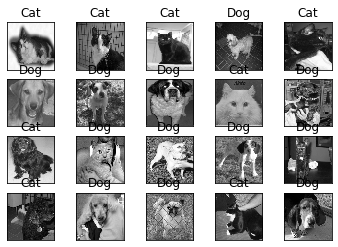

In [16]:
import matplotlib.pyplot as plt

test_data = process_test_data()

fig = plt.figure()

for num, data in enumerate(test_data[:20]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 5, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = "Dog"
    else:
        str_label = "Cat"
    
    y.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()